# TP 3 : Embeddings

<img src="./tp3-header.png" width="1000">

On va s'appuyer sur le corpus collecté par <span class="badge badge-secondary">(Panckhurst et al., 2016)</span> qui rassemble 88,000 sms collectés dans la région de Montpellier. Le corpus a été dé-identifié (en particulier, les noms sont remplacés par [_forename_]). Pour chaque sms, on a identifié les Emojis dans le texte.

Il y avait beaucoup de type d'Emojis. Dans le TP, ils ont été simplifiés selon le tableau suivant. Tous les Emojis de la colonne `Emoji list` ont été remplacé par l'emoji de la colonne `Generic`. Dans le TP les Emojis n'apparaissent pas dans le texte du sms car on cherche à les prédire.


| Generic Emoji  | Emoji list                                                         |
|:--------------:|:------------------------------------------------------------------:|
| 😃             | '=P', ':)', ':P', '=)', ':p', ':d', ':-)', '=D', ':D', '^^'        |
| 😲             | ':O', 'o_o', ':o', ':&'                                            | 
| 😔             | '"-.-'''", '<_>', '-_-', "--'", "-.-'", '-.-', "-.-''", "-\_-'"    | 
| 😠             | ':/', ':-/', ':-(', ':(', ':-<'                                    | 
| 😆             | '>.<', '¤.¤', '<>','><', '*.*', 'xd', 'XD', 'xD', 'x)',';)', ';-)' | 
| 😍             | '</3', '<3'                                                        | 
 

Finalement pour le TP, on a filtré le jeu de données pour ne conserver que les sms contenant qu'un seul Emoji. On a par ailleurs <i>down samplé</i> les classes majoritaires pour limiter le déséquilibre du jeu de données. En effet les sms avec un smiley 😃 était largement sur-représentés.

<b>L'objet du TP est de prédire l'émoji associé à chaque message. Pour cela on vectorisera le texte en utilisant les méthodes d'embeddings.</b>

<span class="badge badge-secondary">(Panckhurst et al., 2016)</span> Panckhurst, Rachel, et al. "88milSMS. A corpus of authentic text messages in French." Banque de corpus CoMeRe. Chanier T.(éd)-Ortolang: Nancy (2016).

In [1]:
# Execute if running in Colab

# !pip install -q scikit-learn==0.23.2 matplotlib==3.1.3 pandas==1.1.3 gensim==3.8.1 torch==1.6.0 torchvision==0.7.0


In [38]:
from gensim.models import KeyedVectors

from collections import Counter
import numpy as np
import pandas as pd
import re

import os, sys
sys.path.append(os.path.abspath('../../m2-data-sciences/src'))

# IPython automatically reload all changed code
%load_ext autoreload
%autoreload 2

# Inline Figures with matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


On va utiliser les embeddings déjà entrainé que nous avons manipulé au cours précédent. Pour limiter la taille du fichier d'embeddings, on a sauvegardé que les `10,000` mots les plus fréquents. <b>Vous devez récupérer le fichier d'embeddings directement sur le Moodle.</b>

In [41]:
w2v_model = KeyedVectors.load_word2vec_format("oscar.fr.300.10k.model")
w2v_model.init_sims(replace=True)

In [42]:
len(w2v_model.vocab)

10000

In [45]:
# On crée un array avec les 10,000 premiers mots et on crée le dictionaire de vocabulaire

word_count = {k: w2v_model.vocab[k].count for k in w2v_model.vocab}
word_count = Counter(word_count)
word_count.most_common(10)

idx2w = {i: w for (i, (w, f)) in enumerate(word_count.most_common(10000))}
w2idx = {w: i for (i, (w, f)) in enumerate(word_count.most_common(10000))}


embeddings_vectors = [w2v_model[w] for (w, f) in word_count.most_common(10000)]
word2vec_embeddings = np.vstack(embeddings_vectors)

In [50]:
word2vec_embeddings.shape

(10000, 300)

In [51]:
w2idx['Oh']

3664

In [55]:
word2vec_embeddings[3664][:10]

array([-0.0133751 , -0.16667102,  0.00242356, -0.01808304, -0.01267814,
        0.05172095,  0.04931232, -0.06592007, -0.05656065,  0.03720263],
      dtype=float32)

In [54]:
w2v_model['Oh'][:10]

array([-0.0133751 , -0.16667102,  0.00242356, -0.01808304, -0.01267814,
        0.05172095,  0.04931232, -0.06592007, -0.05656065,  0.03720263],
      dtype=float32)

<b>Vous devez récupérer le jeu de données directement sur le Moodle.</b>

In [7]:
dataset = pd.read_csv('emojis.csv')

In [57]:
dataset.head()

,Unnamed: 0,Unnamed: 0.1,sms,happy,joke,astonished,angry,bored,heart,filter,tokens
0,1,4,Oh trop mignon mon bbé jsuis au travaiiiil la,False,False,False,False,False,True,True,"[Oh, trop, mignon, mon, bbé, jsuis, au, travai..."
1,3,6,Mon cher et tendre filleul... Je m'engage a et...,False,False,False,False,False,True,True,"[Mon, cher, et, tendre, filleul, ..., Je, m', ..."
2,4,7,Ohhhhhh non ! Héhé j'te texto en mode scred mo...,False,False,False,False,False,True,True,"[Ohhhhhh, non, !, Héhé, j', te, texto, en, mod..."
3,6,11,Non chez mon arriere grand mere juste a coté d...,False,True,False,False,False,False,True,"[Non, chez, mon, arriere, grand, mere, juste, ..."
4,7,14,Demain jai deux heures de pause si tu veux on ...,False,True,False,False,False,False,True,"[Demain, jai, deux, heures, de, pause, si, tu,..."


In [58]:
dataset.loc[3, 'sms']

'Non chez mon arriere grand mere juste a coté de chez mes grands parents'

In [60]:
class_names = ['happy', 'joke', 'astonished', 'angry', 'bored', 'heart']

In [61]:
dataset.shape

(6387, 11)

On va utiliser la même fonction de tokenization qui a été utilisée pour entrainer les embeddings.

In [62]:
token_pattern = re.compile(r"(\->|(?::\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\))|(?:[\d.,]+)|([^\s\w0-9])\2*|(?:[\w0-9\.]+['’]?)(?<!\.))")

def tokenize(text):
    tokens = [groups[0] for groups in re.findall(token_pattern, str(text))]
    tokens = [t.strip() for t in tokens]
    return tokens

In [63]:
dataset['tokens'] = dataset['sms'].apply(tokenize)

In [64]:
dataset.head()

,Unnamed: 0,Unnamed: 0.1,sms,happy,joke,astonished,angry,bored,heart,filter,tokens
0,1,4,Oh trop mignon mon bbé jsuis au travaiiiil la,False,False,False,False,False,True,True,"[Oh, trop, mignon, mon, bbé, jsuis, au, travai..."
1,3,6,Mon cher et tendre filleul... Je m'engage a et...,False,False,False,False,False,True,True,"[Mon, cher, et, tendre, filleul, ..., Je, m', ..."
2,4,7,Ohhhhhh non ! Héhé j'te texto en mode scred mo...,False,False,False,False,False,True,True,"[Ohhhhhh, non, !, Héhé, j', te, texto, en, mod..."
3,6,11,Non chez mon arriere grand mere juste a coté d...,False,True,False,False,False,False,True,"[Non, chez, mon, arriere, grand, mere, juste, ..."
4,7,14,Demain jai deux heures de pause si tu veux on ...,False,True,False,False,False,False,True,"[Demain, jai, deux, heures, de, pause, si, tu,..."


### Exploration de données

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Observer la distribution des classes.</p>
</div>    

In [81]:
for c in class_names:
    print(c, dataset[c].value_counts()[1])

happy 1462
joke 1687
astonished 243
angry 1560
bored 338
heart 1097


In [80]:
for c in class_names:
    print(c, dataset.groupby([c]).count().tokens[1])

happy 1462
joke 1687
astonished 243
angry 1560
bored 338
heart 1097


<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Evaluer la proportion de tokens qui sont hors du vocabulaire des embeddings.</p>
</div>    

In [95]:
# %load solutions/unk.py

tokens_not_in_voc = []

for sms in dataset['tokens']:
    for t in sms:
        tokens_not_in_voc.append(t not in w2idx)

print("On a {:.2f}% des tokens hors du vocab".format(sum(tokens_not_in_voc) / len(tokens_not_in_voc) * 100))

On a 13.40% des tokens hors du vocab


### Vectorization

Les embeddings de mots permettent de représenter chaque <i>token</i> par un vecteur. Pour obtenir un vecteur qui représente le sms, on va agréger les différents mots du texte. On considérera plusieurs fonctions d'agrégation : la somme, la moyenne, me maximum ou le minimum.

En pratique nous verrons dans le dernier cours d'ouverture qu'il existe des méthodes plus évoluées pour composer les mots de la phrase. Néanmoins une simple fonction d'agrégation nous donnera déjà une bonne <i>baseline</i>.

<img src="./model.png" width="500">

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Ecrire une fonction qui permet de vectoriser un sms.</p>
</div>    

In [98]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

In [99]:
dataset['tokens'][0]

['Oh', 'trop', 'mignon', 'mon', 'bbé', 'jsuis', 'au', 'travaiiiil', 'la']

In [104]:
np.zeros_like(embeddings_vectors[0]).shape

(300,)

In [109]:
def vectorize(tokens, agg_method='mean'):
    
    token_embeddings = []
    vect_vide = np.zeros_like(embeddings_vectors[0])
    
    # associer chaque token à son embedding. 
    # Attention, certains tokens peuvent ne pas être dans le vocabulaire
    
    
    for t in tokens:
        if t in w2idx:
            t_idx = w2idx[t]
            token_embeddings.append(embeddings_vectors[t_idx])
        else:
            token_embeddings.append(vect_vide)
            
    token_embeddings_arr = np.array(token_embeddings)
    
    # Agréger les représentations de chaque token.
    # Le vecteur de sortie doit être de taille (300, )
    
    if agg_method == 'mean':
        sentence_embedding = np.mean(token_embeddings_arr, axis=0)
    elif agg_method == 'max':
        sentence_embedding = np.max(token_embeddings_arr, axis=0)
    elif agg_method == 'sum':
        sentence_embedding = np.sum(token_embeddings_arr, axis=0)
    
    return sentence_embedding
    

In [124]:
vectorize(dataset['tokens'][0], agg_method='max')

array([0.00527477, 0.00692021, 0.00242356, 0.06154046, 0.13295795,
       0.06361634, 0.08570134, 0.07414384, 0.        , 0.08212721,
       0.04973175, 0.03402816, 0.06700727, 0.02743915, 0.07400591,
       0.05501981, 0.11267069, 0.0881431 , 0.05800019, 0.09302516,
       0.00409879, 0.02342506, 0.        , 0.0402468 , 0.054419  ,
       0.08634509, 0.05533285, 0.07128762, 0.19060998, 0.02699462,
       0.00081452, 0.09166943, 0.04762873, 0.08533753, 0.03304539,
       0.09167273, 0.04074982, 0.06496961, 0.04717816, 0.06464085,
       0.07810198, 0.11930461, 0.10063915, 0.04590213, 0.1329642 ,
       0.06927311, 0.12643115, 0.02072367, 0.05237858, 0.07072788,
       0.03413792, 0.03463707, 0.00823655, 0.06633823, 0.07935217,
       0.04817078, 0.05091089, 0.05601389, 0.03564481, 0.02593034,
       0.01066518, 0.05512953, 0.07356762, 0.09573206, 0.10821631,
       0.03146662, 0.07366633, 0.        , 0.07214772, 0.14016251,
       0.09438414, 0.05520869, 0.04744984, 0.07238445, 0.09094

In [21]:
# %load solutions/vectorize_1.py


On voudrait attribuer un poids moins important aux embeddings des mots moins caractéristiques. Pour ça, on voudrait pondérer la contribution des vecteurs de chaque mot en fonction de leur score TF-IDF.

<img src="./model-tfidf.png" width="700">

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Uiliser la pondération TF-IDF pour pondérer chacun des vecteurs</p>
</div>    

In [125]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x,
                                   lowercase=False)

tfidf_vectorizer.fit(dataset['tokens'])

w2idx_tfidf = {w: idx for (idx, w) in enumerate(tfidf_vectorizer.get_feature_names())}
idx_tfidf2w = {idx: w for (idx, w) in enumerate(tfidf_vectorizer.get_feature_names())}

/Users/antoine/opt/anaconda3/envs/nlp-101/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [131]:
w2idx_tfidf['Oh']

1230

In [158]:
expl_1_tfidf = tfidf_vectorizer.transform([dataset['tokens'][0]]).todense().transpose()
print(expl_1_tfidf.shape)

(10492, 1)


In [149]:
w2idx_tfidf['Oh']

1230

In [150]:
expl_1_tfidf[1230, 0]

0.2888766247464332

In [148]:
for t in dataset['tokens'][0]:
    print(t, expl_1_tfidf[w2idx_tfidf[t], 0])

Oh 0.2888766247464332
trop 0.22009470142004525
mignon 0.39228804412650337
mon 0.20163143305757703
bbé 0.4862393558550892
jsuis 0.3283377140100523
au 0.21107136353898548
travaiiiil 0.508995935937675
la 0.1603157035024473


In [ ]:
def vectorize(tokens, agg_method='mean', tfidf_vectorizer=None):
    
    token_embeddings = []
    vect_vide = np.zeros_like(embeddings_vectors[0])
    
    # associer chaque token à son embedding. 
    # Attention, certains tokens peuvent ne pas être dans le vocabulaire
    
    
    for t in tokens:
        if t in w2idx:
            t_idx = w2idx[t]
            token_embeddings.append(embeddings_vectors[t_idx])
        else:
            token_embeddings.append(vect_vide)
            
    token_embeddings_arr = np.array(token_embeddings)
    
    # Agréger les représentations de chaque token.
    # Le vecteur de sortie doit être de taille (300, )
    
    if agg_method == 'mean':
        sentence_embedding = np.mean(token_embeddings_arr, axis=0)
    elif agg_method == 'max':
        sentence_embedding = np.max(token_embeddings_arr, axis=0)
    elif agg_method == 'sum':
        sentence_embedding = np.sum(token_embeddings_arr, axis=0)
    elif agg_method == 'tfidf':
        pass
    
    return sentence_embedding

    

In [ ]:
# %load solutions/vectorize_2.py


In [160]:
X = [vectorize(sms) for sms in dataset['tokens']]
X = np.array(X)
print(X.shape)

(6387, 300)


On va intégrer la fonction `vectorize` dans un module compatible avec les fonctions de `sklearn`.

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Intégrer votre fonction de vectorization dans la classe Vectorizer ci-dessous. Vous devez simoplement la copier/coller en replaçant tfidf_vectorizer par self.tfidf_vectorizer car c'est maintenant un attribut de la class.</p>
</div>    

In [ ]:
# 6 choses à faire pour l'excercice sur la class Vectorizer :
# copier votre fonction vectorize dans la class
# ajouter l'argument self dans la fonction vectorize
# supprimer l'argument tfidf_vectorizer de la fonction vectorize
# remplacer toutes les occurences de agg_method par self.agg_method dans la fonction vectorize
# supprimer l'argument agg_method de la fonction vectorize
# remplacer toutes les occurences de w2idx_tfidf par self.w2idx_tfidf dans la fonction vectorize

In [198]:
class Vectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, agg_method='mean', normalize=False):
        self.agg_method = agg_method
        self.normalize = normalize
        self.tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x,
                                                lowercase=False,
                                                token_pattern=None)
        
    def vectorize(self, tokens):
    
        token_embeddings = []
        vect_vide = np.zeros_like(embeddings_vectors[0])

        # associer chaque token à son embedding. 
        # Attention, certains tokens peuvent ne pas être dans le vocabulaire
        
        # self.tfidf_vectorizer

        for t in tokens:
            if t in w2idx:
                t_idx = w2idx[t]
                token_embeddings.append(embeddings_vectors[t_idx])
            else:
                token_embeddings.append(vect_vide)

        token_embeddings_arr = np.array(token_embeddings)

        # Agréger les représentations de chaque token.
        # Le vecteur de sortie doit être de taille (300, )

        if self.agg_method == 'mean':
            sentence_embedding = np.mean(token_embeddings_arr, axis=0)
        elif self.agg_method == 'max':
            sentence_embedding = np.max(token_embeddings_arr, axis=0)
        elif self.agg_method == 'sum':
            sentence_embedding = np.sum(token_embeddings_arr, axis=0)
        elif self.agg_method == 'tfidf':
            pass

        return sentence_embedding

    
    def _vectorize(self, tokens):
        return vectorize(tokens)
    
    def fit(self, X, y=None): 
        self.tfidf_vectorizer.fit(X['tokens'])
        self.w2idx_tfidf = {w: idx for (idx, w) in enumerate(self.tfidf_vectorizer.get_feature_names())}
        self.idx_tfidf2w = {idx: w for (idx, w) in enumerate(self.tfidf_vectorizer.get_feature_names())}
        return self
    
    def transform(self, X, y=None):
        X = [self.vectorize(sms) for sms in X['tokens']]
        X = np.array(X)

        if self.normalize:
            X = X / np.linalg.norm(X + self.eps, axis=1, keepdims=True)
        return X

In [199]:
# %load solutions/vectorizer.py


In [200]:
vectorizer = Vectorizer(agg_method='tfidf-sum')

In [201]:
X = vectorizer.fit_transform(dataset)

In [202]:
X.shape

(6387, 300)

### Classification

In [203]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score

On compare deux algorithmes de classification :  Une régression logistique et un SVM ou l'on pénalise les classes majoritaires.

In [204]:
X_train, X_test = train_test_split(
    dataset, test_size=0.33, random_state=42)

y_train = X_train[['happy', 'joke', 'astonished', 'angry', 'bored', 'heart']].astype(int).values
y_train = [x.tolist().index(1) for x in y_train]

y_test = X_test[['happy', 'joke', 'astonished', 'angry', 'bored', 'heart']].astype(int).values
y_test = [x.tolist().index(1) for x in y_test]

In [205]:
len(y_train)

4279

In [206]:
X_train.shape

(4279, 11)

In [207]:
LogReg_pipeline = Pipeline([
    ('vect', Vectorizer()),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'))),
])


# Training logistic regression model on train data
LogReg_pipeline.fit(X_train, y_train)

# Infering data on test set
prediction_LogReg = LogReg_pipeline.predict(X_test)

In [208]:
SVC_pipeline = Pipeline([
    ('vect', Vectorizer()),
    ('clf', OneVsRestClassifier(SVC(kernel='linear', 
                                    class_weight='balanced', # penalize
                                    probability=True), n_jobs=-1))
])


SVC_pipeline.fit(X_train, y_train)
prediction_SVC = SVC_pipeline.predict(X_test)

### Evaluation

In [209]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from plots import plot_confusion_matrix

Test accuracy is 0.33111954459203036
Test ROC socre is 0.6843670794440725
Confusion matrix, without normalization


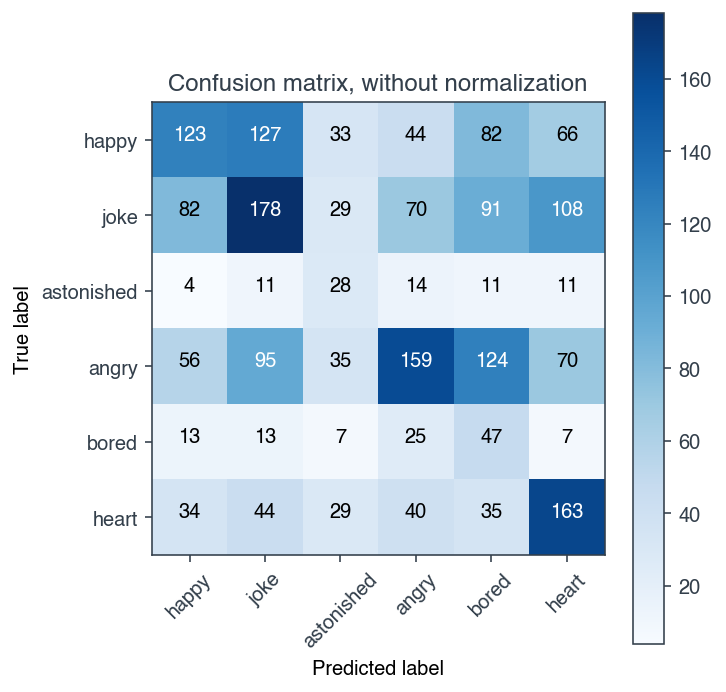

In [210]:
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction_SVC)))
print('Test ROC socre is {}'.format(roc_auc_score(np.eye(np.max(y_test) + 1)[y_test],
                                                  SVC_pipeline.predict_proba(X_test), 
                                                  multi_class='ovo')))

plot_confusion_matrix(confusion_matrix(y_test, prediction_SVC), 
                      classes=class_names, 
                      title='Confusion matrix, without normalization')

Test accuracy is 0.3818785578747628
Test ROC socre is 0.6770894087231892
Confusion matrix, without normalization


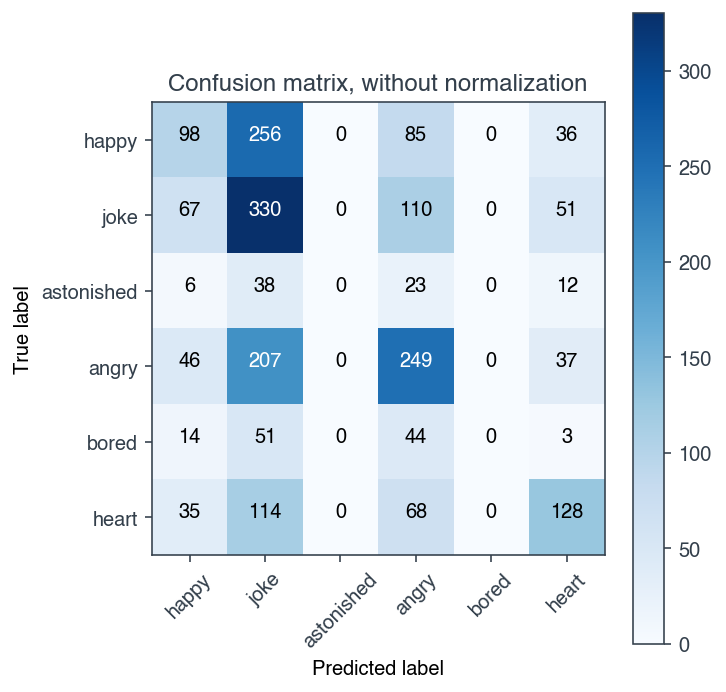

In [211]:
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction_LogReg)))
print('Test ROC socre is {}'.format(roc_auc_score(np.eye(np.max(y_test) + 1)[y_test],
                                                  LogReg_pipeline.predict_proba(X_test), 
                                                  multi_class='ovo')))

plot_confusion_matrix(confusion_matrix(y_test, prediction_LogReg), 
                      classes=class_names, 
                      title='Confusion matrix, without normalization')

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Quelle mesure de performance vous semble le plus adaptée pour ce cas d'usage ?</p>
</div>    

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Comparer les résultats obtenus avec les deux algorithmes de classifications</p>
</div>    

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Comparer les différentes méthodes d'agrégation proposées. (Mean, Max, Sum, Moyenne pondérée par le TF-IDF)</p>
</div>    

L'utilisation des méthodes de down-sampling ou up-sampling peut s'avérer fastidieux (on va se priver de données ou en utiliser d'autres plusieurs fois. La sélection des données doit se faire précisémment pour ne pas impacter les capacités de généralisation de l'algorithme). Nous avons préféré ici utiliser un algorithme qui pénalise les classes majoritaires et une mesure d'erreur adaptée. Il existe un bon article de blog pour gérer les classes déséquilibrées : https://elitedatascience.com/imbalanced-classes. 

On peut se faire une idée des limites et des points fort de l'algorithme en regardant des prédictions.

In [30]:
humors = ['happy', 'astonished', 'bored', 'angry', 'joke', 'heart']
meta_smiley = [b'\xF0\x9F\x98\x83'.decode("utf-8"),
                b'\xF0\x9F\x98\xB2'.decode("utf-8"),
                b'\xF0\x9F\x98\x94'.decode("utf-8"), 
                b'\xF0\x9F\x98\xA0'.decode("utf-8"),
                b'\xF0\x9F\x98\x86'.decode("utf-8"),
                b'\xF0\x9F\x98\x8D'.decode("utf-8")]
humor_2_emoji = {h: ms for (h, ms) in zip(humors, meta_smiley)}

In [31]:
X_test.shape

(2108, 11)

In [183]:
for _ in range(10):
    idx = np.random.randint(0, len(X_test))
    
    emojis = humor_2_emoji[class_names[prediction_SVC[idx]]]
    
    true_emojis = humor_2_emoji[class_names[y_test[idx]]]
    print(X_test['sms'].values[idx], '(Pred)', emojis, '(True)', true_emojis, '\n')
    

En plus tu me mens quand tu dis que tu pars Je t'aime (Pred) 😆 (True) 😆 

Puis frnchement elle note trop mal!!! En langue j ai eu 16 en methode 10 jcrois mais en mm tmps on sait pas la methode qu elle veut donc c est cool (Pred) 😆 (True) 😃 

C'est le bordel dans la famille.. (Pred) 😃 (True) 😠 

Mais mon coeur pourquoi tu veut pas qu'on S'appel ? J'ai rien fait de mal.... (Pred) 😠 (True) 😠 

Mm en effet (Pred) 😃 (True) 😃 

Oui!! En plus après demain elle part en Algérie!! On aurait plus eu l'occasion de la voir avant deux semaines!!! (Pred) 😆 (True) 😍 

Je dors amour! A demain, 13h (Pred) 😍 (True) 😍 

Beaucoup mon cheri... Jveux etre aux vacances.. Flemme de tout bosser, mes partiels, dossiers et oraux.. (Pred) 😔 (True) 😠 

Gueule de bois? (Pred) 😲 (True) 😆 

A demain j'ai trop mal. Je t'aime fort mon amour (Pred) 😍 (True) 😍 



### Visualisation

On peut aussi essayer de visualiser plus globalement les représentations. Pour ça on peut utiliser des algorithmes de réduction de dimension pour visualiser nos données. On a déjà parlé de UMAP et t-SNE. De manière intutive, l'algorithme projete les représentations dans un espace de plus faible dimension en s'efforcant de respecter les distances entre les points entre l'espace de départ et d'arrivée. Il permet de visualiser facilement les données. On va utiliser l'outil `Tensorboard` qui intègre les principales méthodes de réduction de dimensions.

In [33]:
from pathlib import Path
from PIL import Image
import os
from os import listdir
from os.path import isfile, join
from torchvision import transforms

from torch.utils.tensorboard import SummaryWriter
import torch

In [34]:
pil_img = Image.open('./smileys/happy.png').convert('RGB')
pil_img = pil_img.resize((100, 100)) 

In [35]:
smileys_images = [f for f in listdir('./smileys') if isfile(join('./smileys', f))]

In [36]:
imgs_tb = {}
for s in smileys_images:
    pil_img = Image.open(os.path.join('smileys', s)).convert('RGB')
    pil_img = pil_img.resize((25, 25)) 
    pil_to_tensor = transforms.ToTensor()(pil_img).unsqueeze_(0)
    imgs_tb[Path(os.path.join('smileys', s)).stem] = pil_to_tensor

In [37]:
writer_embeddings = SummaryWriter(log_dir=os.path.join("./tfb/"))

vectorizer = Vectorizer(agg_method='tfidf', normalize=True)
emb_test = vectorizer.fit_transform(X_test)

writer_embeddings.add_embedding(torch.tensor(emb_test),
                                metadata=[(r, s, l) for (r, s, l) in zip(
                                    X_test['sms'].values,
                                    [humor_2_emoji[class_names[y]] for y in y_test],
                                    [humor_2_emoji[class_names[y]] for y in prediction_SVC])
                                ],
                                label_img=torch.cat([imgs_tb[class_names[y]] for y in y_test]),
                                metadata_header=['sms','label', 'prediction'],
                                tag="SMS-EMB-CLS")

Pour visualiser les représentations, lancer un tensorboard. Dans un terminal, se placer dans le dossier ou est éxécuté le notebook et exécuter:

```
tensorboard --logdir ./tfb/
```

Dans **Colab** on va lancer le tensorboard directement dans le notebook en éxécutant les cellules suivante :

```
%load_ext tensorboard
```

```
%tensorboard --logdir ./tfb/
```

Vous devriez avoir un visuel comme ci-dessous. Vous pouvez cliquer sur un sms et vous avez à droite les sms les plus proches en terme de distance cosine comme nous l'avons fait pour word2vec. Par ailleurs chaque sms est représenté par le smiley correspondant. Vous pouvez faire varier les méthodes de projection dans le panneau de gauche.

<img src="./tfb-viz.png" width="1000">

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Utiliser les méthodes UMAP, PCA et t-SNE pour projeter les données. Comparez les différentes méthodes de projections et interprétez qualitativement les propriétés de vos représentations.</p>
</div>    